## Import library

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn


## Import Env File

In [2]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('AUGMENTED_PATH_JOGJA_PEKALONGAN')
models_path = os.getenv('MODELS_PATH')

In [3]:
os.listdir(datasets_path)

['jogja', 'pekalongan']

## Device Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Parameters

In [5]:
num_classes = 2
batch_size = 16
test_split_ratio = 0.2
val_split_ratio = 0.2

## Data Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Custom Dataset With GLCM Features

In [24]:
from torch.utils.data import Dataset
import numpy as np
import cv2
import torch
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler

class GLCMCNNHybridDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform
        # Simpan fitur GLCM dan label
        self.glcm_features = []
        self.labels = []

        print("🔄 Preprocessing GLCM features...")

        for idx in range(len(image_folder_dataset)):
            image, label = image_folder_dataset[idx]

            # Simpan label
            self.labels.append(label)

            # Transform dulu (pakai transform yg sama dengan training)
            if self.transform:
                image = self.transform(image)

            # Convert tensor (C, H, W) -> numpy image (H, W, C)
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)

            # Ekstrak GLCM
            gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
            distances = [1, 2, 3]
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
            props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
            features = []
            for prop in props:
                values = graycoprops(glcm, prop)
                features.extend(values.flatten())
            features = np.array(features, dtype=np.float32)
    
            self.glcm_features.append(features)

        self.glcm_features = np.array(self.glcm_features, dtype=np.float32)
        scaler = StandardScaler()
        self.glcm_features = scaler.fit_transform(self.glcm_features)
        self.glcm_features = torch.tensor(self.glcm_features, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        print("✅ GLCM features extracted and cached.")

    def __len__(self):
        return len(self.image_folder_dataset)

    def __getitem__(self, index):
        image, _ = self.image_folder_dataset[index]  # label diambil dari self.labels

        if self.transform:
            image = self.transform(image)

        glcm_feature = self.glcm_features[index]
        label = self.labels[index]

        return image, glcm_feature, label

## Data Loaders

In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Buat dataset dasar
base_dataset = datasets.ImageFolder(root=datasets_path)
hybrid_dataset = GLCMCNNHybridDataset(base_dataset, transform=transform)

# Ambil semua label
targets = base_dataset.targets
indices = list(range(len(base_dataset)))

# Pertama: Bagi data menjadi train+val dan test
trainval_indices, test_indices = train_test_split(
    indices,
    test_size=test_split_ratio,
    stratify=targets,
    random_state=42
)

# Ambil label untuk data trainval
trainval_targets = [targets[i] for i in trainval_indices]

# Kedua: Bagi trainval menjadi train dan val
train_indices, val_indices = train_test_split(
    trainval_indices,
    test_size=val_split_ratio,
    stratify=trainval_targets,
    random_state=42
)

# Buat subset dataset-nya
train_dataset = Subset(hybrid_dataset, train_indices)
val_dataset = Subset(hybrid_dataset, val_indices)
test_dataset = Subset(hybrid_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

🔄 Preprocessing GLCM features...
✅ GLCM features extracted and cached.


In [26]:
# Cek dimensi glcm_features
for images, glcm_features, labels in train_loader:
    print("Shape GLCM Features:", glcm_features.shape)
    break

Shape GLCM Features: torch.Size([16, 60])


## Load Pre-Trained Model (EfficientNet)

In [27]:
# Load EfficientNet-B0
weights = EfficientNet_B0_Weights.DEFAULT
cnn_model = efficientnet_b0(weights=weights)
cnn_feature_size = cnn_model.classifier[1].in_features  # EfficientNet features

# Replace classification layer to get features
cnn_model.classifier = nn.Identity()
cnn_model = cnn_model.to(device)

In [28]:
print(cnn_feature_size)

1280


## Hybrid Model

In [13]:
class PararelModel(nn.Module):
    def __init__(self, cnn_model, glcm_feature_size, cnn_feature_size, num_classes):
        super(PararelModel, self).__init__()
        self.cnn_model = cnn_model
        self.fc1 = nn.Linear(glcm_feature_size + cnn_feature_size, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, image, glcm_features):
        cnn_features = self.cnn_model(image)
        combined_features = torch.cat((glcm_features, cnn_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Simplified Hybrid Model

In [29]:
class SimpleParallelModel(nn.Module):
    def __init__(self, cnn_model, glcm_feature_size, cnn_feature_size, num_classes):
        super(SimpleParallelModel, self).__init__()
        self.cnn_model = cnn_model
        self.fc1 = nn.Linear(glcm_feature_size + cnn_feature_size, 256)  # Menurunkan dimensi
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)  # Langsung ke output class

    def forward(self, image, glcm_features):
        cnn_features = self.cnn_model(image)
        combined_features = torch.cat((glcm_features, cnn_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Initialize Hybrid Model

In [30]:
glcm_feature_size = 60  # Number of GLCM features
# model = PararelModel(cnn_model, glcm_feature_size, cnn_feature_size, num_classes).to(device)
model = SimpleParallelModel(cnn_model, glcm_feature_size, cnn_feature_size, num_classes).to(device)

## Train The Model

In [31]:
num_epochs = 50
patience = 5  # jumlah epoch tanpa perbaikan sebelum berhenti
best_loss = float('inf')
epochs_no_improve = 0

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
#                                                        factor=0.5, patience=2, verbose=True)

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, glcm_features, labels in data_loader:
            images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)
            outputs = model(images, glcm_features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training loop dengan early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, glcm_features, labels in train_loader:
        images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, glcm_features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early Stopping Check
    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'temp/best_model_hybrid.pth')  # Simpan model terbaik
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break


Epoch [1/50], Loss: 0.6559, Val Acc: 0.7368
Epoch [2/50], Loss: 0.5495, Val Acc: 0.8092
Epoch [3/50], Loss: 0.4624, Val Acc: 0.8553
Epoch [4/50], Loss: 0.3762, Val Acc: 0.8750
Epoch [5/50], Loss: 0.3013, Val Acc: 0.8947
Epoch [6/50], Loss: 0.2829, Val Acc: 0.9211
Epoch [7/50], Loss: 0.2067, Val Acc: 0.9342
Epoch [8/50], Loss: 0.1634, Val Acc: 0.9342
Epoch [9/50], Loss: 0.1090, Val Acc: 0.9474
Epoch [10/50], Loss: 0.1058, Val Acc: 0.9474
Epoch [11/50], Loss: 0.0953, Val Acc: 0.9408
Epoch [12/50], Loss: 0.1057, Val Acc: 0.9474
Epoch [13/50], Loss: 0.1335, Val Acc: 0.9539
Epoch [14/50], Loss: 0.0593, Val Acc: 0.9539
Epoch [15/50], Loss: 0.0802, Val Acc: 0.9474
Epoch [16/50], Loss: 0.0455, Val Acc: 0.9605
Epoch [17/50], Loss: 0.0468, Val Acc: 0.9605
Epoch [18/50], Loss: 0.0548, Val Acc: 0.9737
Epoch [19/50], Loss: 0.0373, Val Acc: 0.9605
Epoch [20/50], Loss: 0.0416, Val Acc: 0.9671
Epoch [21/50], Loss: 0.0412, Val Acc: 0.9737
Epoch [22/50], Loss: 0.0284, Val Acc: 0.9408
Epoch [23/50], Loss

## Evaulation


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        75
           1       0.99      0.96      0.97        77

    accuracy                           0.97       152
   macro avg       0.97      0.97      0.97       152
weighted avg       0.97      0.97      0.97       152



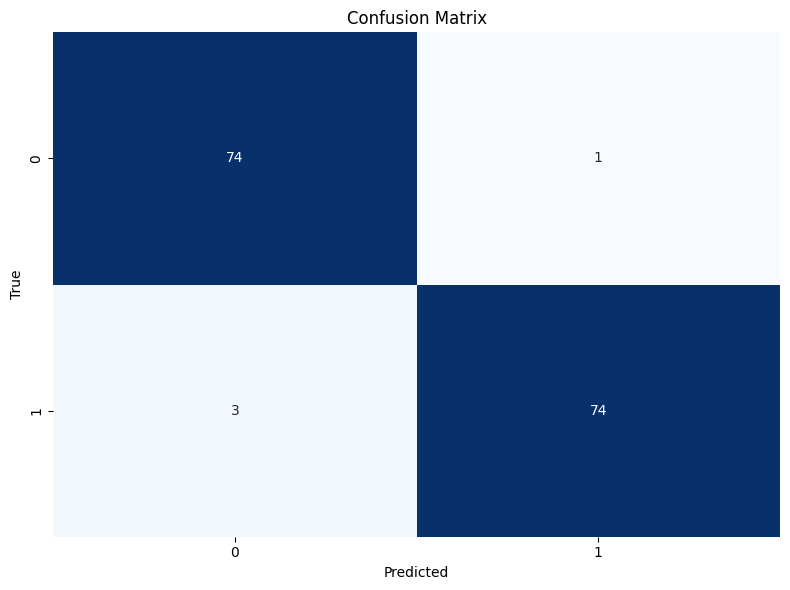

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, glcm_features, labels in test_loader:
        images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)
        outputs = model(images, glcm_features)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung precision, recall, f1 untuk setiap kelas
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

# Tampilkan nilai precision, recall, dan f1-score per kelas
num_classes = len(set(all_labels))  # Jumlah kelas yang ada di dataset
# for i in range(num_classes):
#     print(f"Class {i}:")
#     print(f"  Precision: {precision[i]:.4f}")
#     print(f"  Recall:    {recall[i]:.4f}")
#     print(f"  F1-Score:  {f1[i]:.4f}")
#     print("-" * 30)

# Tampilkan classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## Save The Model

In [35]:
torch.save(model.state_dict(), models_path+'/hybrid_glcm_cnn_modelv2.pth')